In [1]:
from pyspark import SparkContext # type: ignore
from pyspark.streaming import StreamingContext # type: ignore
from pyspark.sql import SparkSession # type: ignore
from pyspark.sql.functions import * # type: ignore
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover, Word2Vec # type: ignore
from pyspark.ml.classification import NaiveBayes, LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier  # type: ignore
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # type: ignore
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import ArrayType, FloatType

import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [26]:
import pyspark
print(pyspark.__version__)

3.5.0


In [2]:
spark = SparkSession.builder.appName("SentimentAnalysis") \
.config("spark.executor.memory", "8g") \
.config("spark.driver.memory", "8g") \
.config("spark.executor.cores", "2") \
.config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()
# spark.sparkContext.setLogLevel("Test")

24/12/05 21:27:03 WARN Utils: Your hostname, MacBook-Air-cua-Trung.local resolves to a loopback address: 127.0.0.1; using 192.168.0.102 instead (on interface en0)
24/12/05 21:27:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/05 21:27:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data = "twitter_training.csv"
columns = ["id", "kind", "label", "tweet"]
# df = spark.read.csv(data, header=True, inferSchema=True).toDF("number", "label", "anything", "tweet")
df = spark.read.csv(data, header=True, inferSchema=True).toDF(*columns)
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- kind: string (nullable = true)
 |-- label: string (nullable = true)
 |-- tweet: string (nullable = true)



In [4]:
df.count()

74681

In [30]:
lines = spark.readStream.format("socket").option("host", "localhost").option("port", 9999).load()

24/11/25 01:05:07 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.


Preprocessing data

In [5]:
cleaned_df = df.withColumn("tweet", lower(col("tweet"))) \
    .withColumn("tweet", regexp_replace(col("tweet"), r"#|@\S+", " ")) \
    .withColumn("tweet", regexp_replace(col("tweet"), r"https\S+", " ")) \
    .withColumn("tweet", regexp_replace(col("tweet"), r"[^a-zA-Z0-9]", " ")) \
    .fillna({"tweet": ""})

In [6]:
cleaned_df.show()

+----+-----------+--------+--------------------+
|  id|       kind|   label|               tweet|
+----+-----------+--------+--------------------+
|2401|Borderlands|Positive|i am coming to th...|
|2401|Borderlands|Positive|im getting on bor...|
|2401|Borderlands|Positive|im coming on bord...|
|2401|Borderlands|Positive|im getting on bor...|
|2401|Borderlands|Positive|im getting into b...|
|2402|Borderlands|Positive|so i spent a few ...|
|2402|Borderlands|Positive|so i spent a coup...|
|2402|Borderlands|Positive|so i spent a few ...|
|2402|Borderlands|Positive|so i spent a few ...|
|2402|Borderlands|Positive|2010 so i spent a...|
|2402|Borderlands|Positive|                 was|
|2403|Borderlands| Neutral|rock hard la varl...|
|2403|Borderlands| Neutral|rock hard la varl...|
|2403|Borderlands| Neutral|rock hard la varl...|
|2403|Borderlands| Neutral|rock hard la vita...|
|2403|Borderlands| Neutral|live rock   hard ...|
|2403|Borderlands| Neutral|i hard like me  r...|
|2404|Borderlands|Po

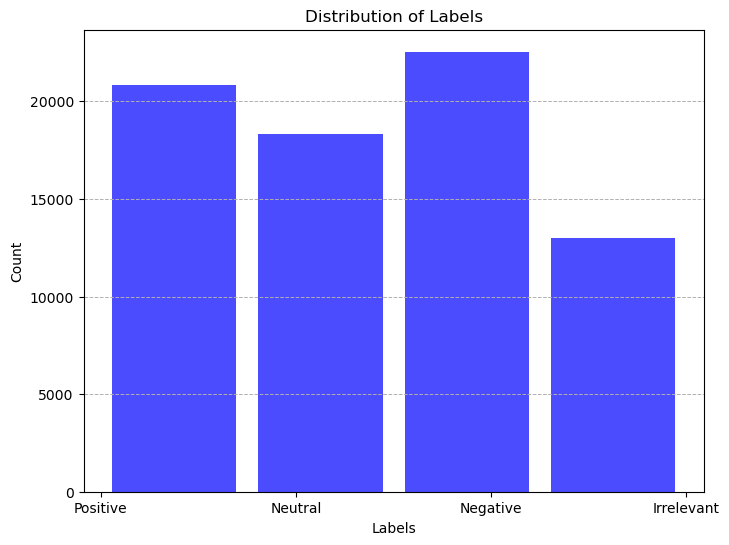

In [7]:
labels = [row['label'] for row in cleaned_df.collect()]
plt.figure(figsize=(8, 6))
plt.hist(labels, bins=len(set(labels)), color='blue', alpha=0.7, rwidth=0.85)
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

In [9]:
cleaned_df.write.csv('tweets_data')

In [8]:
cleaned_df.where(col("tweet").isNull()).count()

0

Tokenizer

In [8]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
wordsData = tokenizer.transform(cleaned_df)

In [9]:
wordsData.select("label", "words").show()

+--------+--------------------+
|   label|               words|
+--------+--------------------+
|Positive|[i, am, coming, t...|
|Positive|[im, getting, on,...|
|Positive|[im, coming, on, ...|
|Positive|[im, getting, on,...|
|Positive|[im, getting, int...|
|Positive|[so, i, spent, a,...|
|Positive|[so, i, spent, a,...|
|Positive|[so, i, spent, a,...|
|Positive|[so, i, spent, a,...|
|Positive|[2010, so, i, spe...|
|Positive|               [was]|
| Neutral|[rock, hard, la, ...|
| Neutral|[rock, hard, la, ...|
| Neutral|[rock, hard, la, ...|
| Neutral|[rock, hard, la, ...|
| Neutral|[live, rock, , , ...|
| Neutral|[i, hard, like, m...|
|Positive|[that, was, the, ...|
|Positive|[this, was, the, ...|
|Positive|[that, was, the, ...|
+--------+--------------------+
only showing top 20 rows



In [10]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_df = remover.transform(wordsData)

24/12/05 21:27:28 WARN StopWordsRemover: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [11]:
filtered_df.show()

+----+-----------+--------+--------------------+--------------------+--------------------+
|  id|       kind|   label|               tweet|               words|      filtered_words|
+----+-----------+--------+--------------------+--------------------+--------------------+
|2401|Borderlands|Positive|i am coming to th...|[i, am, coming, t...|[coming, borders,...|
|2401|Borderlands|Positive|im getting on bor...|[im, getting, on,...|[im, getting, bor...|
|2401|Borderlands|Positive|im coming on bord...|[im, coming, on, ...|[im, coming, bord...|
|2401|Borderlands|Positive|im getting on bor...|[im, getting, on,...|[im, getting, bor...|
|2401|Borderlands|Positive|im getting into b...|[im, getting, int...|[im, getting, bor...|
|2402|Borderlands|Positive|so i spent a few ...|[so, i, spent, a,...|[spent, hours, ma...|
|2402|Borderlands|Positive|so i spent a coup...|[so, i, spent, a,...|[spent, couple, h...|
|2402|Borderlands|Positive|so i spent a few ...|[so, i, spent, a,...|[spent, hours, so...|

TF-IDF

In [12]:
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures")
featurized_df = hashingTF.transform(filtered_df)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_df)
rescaled_df = idf_model.transform(featurized_df)

In [13]:
rescaled_df.select("label", "features").show()

+--------+--------------------+
|   label|            features|
+--------+--------------------+
|Positive|(262144,[12409,14...|
|Positive|(262144,[31015,23...|
|Positive|(262144,[12409,31...|
|Positive|(262144,[12524,31...|
|Positive|(262144,[31015,92...|
|Positive|(262144,[531,1512...|
|Positive|(262144,[531,1512...|
|Positive|(262144,[19698,21...|
|Positive|(262144,[531,1512...|
|Positive|(262144,[531,1512...|
|Positive|      (262144,[],[])|
| Neutral|(262144,[2437,988...|
| Neutral|(262144,[2437,988...|
| Neutral|(262144,[2437,988...|
| Neutral|(262144,[2437,988...|
| Neutral|(262144,[2437,988...|
| Neutral|(262144,[2437,432...|
|Positive|(262144,[16793,55...|
|Positive|(262144,[55875,11...|
|Positive|(262144,[16793,55...|
+--------+--------------------+
only showing top 20 rows



24/12/05 21:27:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


In [14]:
# label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
final_df = rescaled_df.withColumn("label", 
                                  when(col('label') == 'Negative', 0)
                                  .when(col('label') == 'Neutral', 1)
                                  .when(col('label') == 'Positive', 2)
                                  .when(col('label') == 'Irrelevant', 3))

In [15]:
final_df.show()

+----+-----------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|  id|       kind|label|               tweet|               words|      filtered_words|         rawFeatures|            features|
+----+-----------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|2401|Borderlands|    2|i am coming to th...|[i, am, coming, t...|[coming, borders,...|(262144,[12409,14...|(262144,[12409,14...|
|2401|Borderlands|    2|im getting on bor...|[im, getting, on,...|[im, getting, bor...|(262144,[31015,23...|(262144,[31015,23...|
|2401|Borderlands|    2|im coming on bord...|[im, coming, on, ...|[im, coming, bord...|(262144,[12409,31...|(262144,[12409,31...|
|2401|Borderlands|    2|im getting on bor...|[im, getting, on,...|[im, getting, bor...|(262144,[12524,31...|(262144,[12524,31...|
|2401|Borderlands|    2|im getting into b...|[im, getting, int...|[im, getting, bor...|(26

24/12/05 21:27:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


In [16]:
training_data, test_data = final_df.randomSplit([0.8, 0.2],  seed=1234)

model = {"Naive Bayes": NaiveBayes(featuresCol="features", labelCol="label"),
         "Logistic Regression": LogisticRegression(featuresCol="features", labelCol="label"),
         #"DecisionTreeClassifier": DecisionTreeClassifier(featuresCol="features", labelCol="label"),
         #"Random Forest": RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=5)
         }

Naive Bayes


24/12/05 21:27:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:27:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:27:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:27:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:27:55 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
24/12/05 21:27:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/05 21:27:55 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:27:56 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:27:56 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:27:57 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:27:58 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
24/12/05 21:27:58 WARN DAGSched

Naive Bayes: 0.7837693539775761


24/12/05 21:28:02 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


<Figure size 800x600 with 0 Axes>

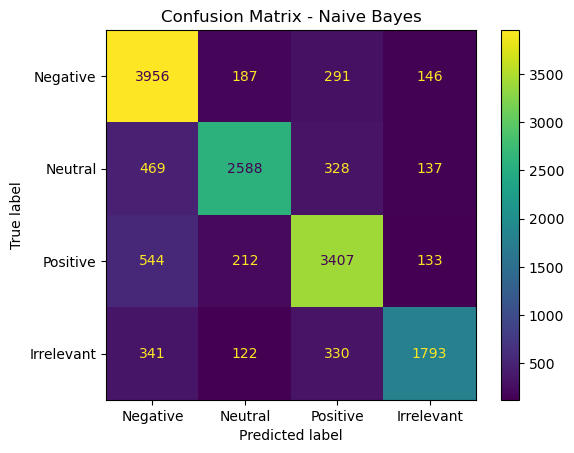

Logistic Regression


24/12/05 21:28:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:28:04 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:28:04 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:28:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:28:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:28:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:28:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:28:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:28:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:28:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:28:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/05 21:28:07 WARN DAGScheduler: Broadcasting larg

Logistic Regression: 0.8279498131340096


24/12/05 21:29:40 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


<Figure size 800x600 with 0 Axes>

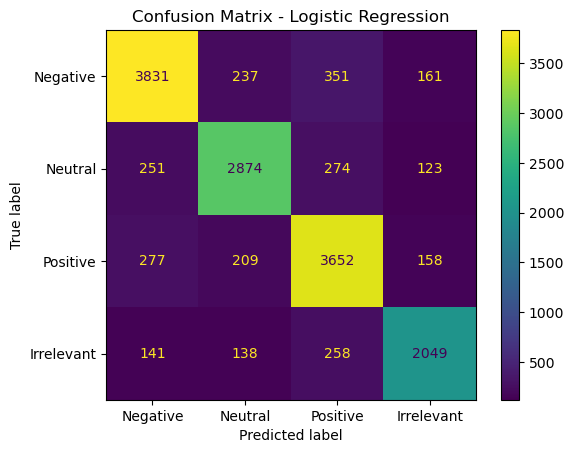

In [17]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)

results = {}
for model_name, model in model.items():
    print(model_name)
    params = ParamGridBuilder().build()
    crossval = CrossValidator(estimator=model, estimatorParamMaps=params, evaluator=evaluator, numFolds=2, parallelism=1)
    cv_model = crossval.fit(training_data)
    predictions = cv_model.transform(test_data)
    accuracy = evaluator.evaluate(predictions)
    results[model_name] = accuracy
    print(f"{model_name}: {accuracy}")
    y_true = predictions.select("label").rdd.flatMap(lambda x: x).collect()
    y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive", "Irrelevant"])
    disp.plot(cmap="viridis", values_format="d")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

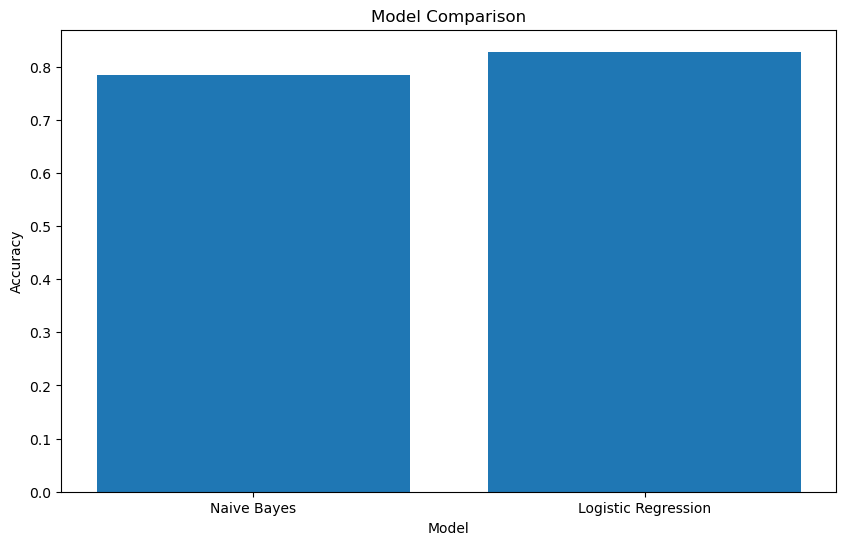

In [18]:
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()